## Random Forest Regression for Air Quality Forecasting

This notebook trains Random Forest models to predict pollutant concentrations at t+1h, t+6h, t+12h, and t+24h for CO(GT), C6H6(GT), NOx(GT), and NO2(GT). 

We use 200 trees and compare against a naive baseline (lag1 prediction). Features exclude current ground truth pollutants to match deployment conditions. NMHC(GT) is excluded due to ~90% missing values.

**Data:** Train on 2004, test on 2005 (chronological split).

**Features:** Engineered features from `dataset/AirQualityUCI_features.csv`:
- Lag features (1h, 6h, 12h, 24h)
- Rolling statistics (6h and 24h windows)
- Temporal encodings (hour, day of week, month)
- Sensor readings (PT08.S1-S5) and meteorological data (T, RH, AH)

**Outputs:**
- `random_forest_notebook_summary.csv` - RMSE, MAE, R² for all models
- `random_forest_feature_importances.csv` - Feature rankings
- `CO_GT_pred_vs_true_h1.png` - Single horizon example
- `rf_predictions_all_horizons.png` - Multi-horizon plots (CO)
- `rf_residuals_all_horizons.png` - Residual analysis (CO)

In [1]:
# Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
from typing import Tuple, Optional

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

FEATURES_PATH = Path('../../../dataset/AirQualityUCI_features.csv')
RESULTS_DIR = Path('results')
PLOTS_DIR = RESULTS_DIR / 'plots'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_columns', 120)
print('Using features file:', FEATURES_PATH)

Environment ready. Using features file: ../../../dataset/AirQualityUCI_features.csv


In [2]:
# Load data
if not FEATURES_PATH.exists():
    raise FileNotFoundError(f"Features file missing at {FEATURES_PATH}")

df = pd.read_csv(FEATURES_PATH)
df['DateTime'] = pd.to_datetime(df['DateTime'])

required_cols = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
missing_required = [c for c in required_cols if c not in df.columns]
if missing_required:
    print('Warning: Missing pollutants:', missing_required)

pollutants_with_targets = sorted({c.split('_t+')[0] for c in df.columns if '_t+' in c})
print('Pollutants with targets:', pollutants_with_targets)
print('Shape:', df.shape)

df.head(3)

Pollutants with future targets: ['C6H6(GT)', 'CO(GT)', 'CO_bin', 'NO2(GT)', 'NOx(GT)']
DataFrame shape: (9309, 103)


,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,Day,Month,hour,dayofweek,month,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,CO(GT)_lag1,CO(GT)_lag6,CO(GT)_lag12,CO(GT)_lag24,C6H6(GT)_lag1,C6H6(GT)_lag6,C6H6(GT)_lag12,C6H6(GT)_lag24,NOx(GT)_lag1,NOx(GT)_lag6,NOx(GT)_lag12,NOx(GT)_lag24,NO2(GT)_lag1,NO2(GT)_lag6,NO2(GT)_lag12,NO2(GT)_lag24,PT08.S1(CO)_lag1,PT08.S1(CO)_lag6,PT08.S1(CO)_lag12,PT08.S1(CO)_lag24,PT08.S2(NMHC)_lag1,PT08.S2(NMHC)_lag6,PT08.S2(NMHC)_lag12,PT08.S2(NMHC)_lag24,PT08.S3(NOx)_lag1,PT08.S3(NOx)_lag6,PT08.S3(NOx)_lag12,PT08.S3(NOx)_lag24,PT08.S4(NO2)_lag1,PT08.S4(NO2)_lag6,PT08.S4(NO2)_lag12,PT08.S4(NO2)_lag24,PT08.S5(O3)_lag1,PT08.S5(O3)_lag6,PT08.S5(O3)_lag12,PT08.S5(O3)_lag24,CO(GT)_roll_mean_6h,CO(GT)_roll_std_6h,CO(GT)_roll_mean_24h,CO(GT)_roll_std_24h,C6H6(GT)_roll_mean_6h,C6H6(GT)_roll_std_6h,C6H6(GT)_roll_mean_24h,C6H6(GT)_roll_std_24h,NOx(GT)_roll_mean_6h,NOx(GT)_roll_std_6h,NOx(GT)_roll_mean_24h,NOx(GT)_roll_std_24h,NO2(GT)_roll_mean_6h,NO2(GT)_roll_std_6h,NO2(GT)_roll_mean_24h,NO2(GT)_roll_std_24h,NOx_NO2_ratio,C6H6_CO_ratio,PT08.S1(CO)_minus_CO(GT),PT08.S3(NOx)_minus_NOx(GT),PT08.S4(NO2)_minus_NO2(GT),CO(GT)_t+1,CO(GT)_t+6,CO(GT)_t+12,CO(GT)_t+24,C6H6(GT)_t+1,C6H6(GT)_t+6,C6H6(GT)_t+12,C6H6(GT)_t+24,NOx(GT)_t+1,NOx(GT)_t+6,NOx(GT)_t+12,NOx(GT)_t+24,NO2(GT)_t+1,NO2(GT)_t+6,NO2(GT)_t+12,NO2(GT)_t+24,CO_bin_t+1,CO_bin_t+6,CO_bin_t+12,CO_bin_t+24
0,2004-03-11 18:00:00,0.398305,0.670495,0.325472,0.511196,0.188896,0.202033,0.440828,0.688849,0.516073,0.262366,0.691824,0.303866,18,3,3,18,3,3,0,-1.000000,-1.836970e-16,0.433884,-0.900969,1.0,6.123234e-17,0.237288,0.127119,0.050847,0.211864,0.174528,0.080189,0.023585,0.185535,0.163169,0.069059,0.021666,0.111036,0.393491,0.275148,0.136095,0.328402,0.528356,0.422828,0.290739,0.511845,0.347897,0.213545,0.092845,0.362097,0.290555,0.414655,0.599746,0.310885,0.525180,0.382194,0.301259,0.513040,0.383579,0.192441,0.109036,0.454822,0.230226,0.089272,0.139654,0.079552,0.176363,0.077523,0.102463,0.069646,0.140149,0.032035,0.079469,0.04793,0.380178,0.037645,0.274285,0.097649,0.428502,0.817140,0.272190,0.013137,0.248021,0.576271,0.135593,0.059322,0.322034,0.429245,0.091195,0.026730,0.301887,0.257955,0.081246,0.036561,0.138118,0.502959,0.281065,0.204142,0.434911,low,low,low,low
1,2004-03-11 19:00:00,0.576271,0.810481,0.429245,0.603495,0.257955,0.160949,0.502959,0.801259,0.644222,0.249462,0.755975,0.316278,19,3,3,19,3,3,0,-0.965926,2.588190e-01,0.433884,-0.900969,1.0,6.123234e-17,0.398305,0.152542,0.084746,0.161017,0.325472,0.113208,0.048742,0.146226,0.188896,0.097495,0.064997,0.068382,0.440828,0.325444,0.236686,0.266272,0.670495,0.458722,0.356784,0.463029,0.511196,0.265429,0.155106,0.312398,0.202033,0.355781,0.494706,0.360864,0.688849,0.443345,0.354317,0.453237,0.516073,0.251086,0.221112,0.326238,0.300847,0.157248,0.156956,0.119519,0.229036,0.121131,0.114256,0.096256,0.166892,0.050792,0.087367,0.06010,0.409763,0.052751,0.284147,0.108187,0.512875,0.744866,0.234210,-0.097007,0.298300,0.508475,0.152542,0.110169,0.305085,0.375786,0.099057,0.067610,0.284591,0.236290,0.088693,0.072444,0.135410,0.482249,0.319527,0.301775,0.423077,low,low,low,low
2,2004-03-11 20:00:00,0.508475,0.712850,0.375786,0.557619,0.236290,0.178314,0.482249,0.737410,0.622502,0.247312,0.737107,0.307189,20,3,3,20,3,3,0,-0.866025,5.000000e-01,0.433884,-0.900969,1.0,6.123234e-17,0.576271,0.237288,0.161017,0.177966,0.429245,0.179245,0.124214,0.139937,0.257955,0.138795,0.116452,0.087339,0.502959,0.372781,0.325444,0.331361,0.810481,0.519742,0.492462,0.541996,0.603495,0.355543,0.282359,0.303659,0.160949,0.279966,0.344769,0.346463,0.801259,0.530126,0.434353,0.451439,0.644222,0.354474,0.382711,0.370547,0.346045,0.173463,0.170727,0.139428,0.261792,0.131135,0.124083,0.110043,0.183142,0.055392,0.093574,0.06735,0.428008,0.056218,0.290434,0.115207,0.489974,0.739045,0.204375,-0.057976,0.255162,0.322034,0.110169,0.364407,0.550847,0.19

In [3]:
# Split: train on 2004, test on 2005
train_df = df[df['DateTime'].dt.year < 2005].copy()
test_df  = df[df['DateTime'].dt.year >= 2005].copy()
print(f"Train: {train_df['DateTime'].min()} -> {train_df['DateTime'].max()} ({len(train_df)} rows)")
print(f"Test:  {test_df['DateTime'].min()} -> {test_df['DateTime'].max()} ({len(test_df)} rows)")

Train: 2004-03-11 18:00:00 -> 2004-12-31 23:00:00 | rows=7086
Test : 2005-01-01 00:00:00 -> 2005-04-03 14:00:00 | rows=2223


## Data Split

We use a chronological split to avoid data leakage:
- **Train:** All 2004 data (used to fit models)
- **Test:** All 2005 data (held out for evaluation)

This simulates deployment at the end of 2004, evaluated on future 2005 data.

## Feature Selection

For realistic forecasting, we exclude features not available at prediction time:

**Excluded:**
- Current ground truth pollutants (CO(GT), C6H6(GT), NOx(GT), NO2(GT), NMHC(GT)) - require lab analysis
- Ratio/residual features derived from current GT
- Future targets (*_t+1, *_t+6, etc.)
- Classification bins

**Included:**
- Sensor readings (PT08.S1-S5)
- Meteorological data (T, RH, AH)
- Temporal features (hour, day, month encodings)
- Lagged GT values (CO(GT)_lag1, etc.) - historical measurements available at prediction time
- Lagged sensors and rolling statistics

This matches the XGBoost feature selection for consistency.

In [4]:
# Build feature list excluding unavailable features
all_cols = df.columns.tolist()
exclude_cols = ['DateTime']

# Current GT pollutants not available in real-time
ground_truth_pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)']
for gt in ground_truth_pollutants:
    if gt in all_cols:
        exclude_cols.append(gt)

# Ratio features derived from current GT
ratio_features = ['NOx_NO2_ratio', 'C6H6_CO_ratio']
for col in all_cols:
    if any(ratio in col for ratio in ratio_features):
        exclude_cols.append(col)

# Residual features (sensor minus current GT)
for col in all_cols:
    if '_minus_' in col:
        exclude_cols.append(col)

# Future targets (what we're predicting)
for col in all_cols:
    if '_t+' in col:
        exclude_cols.append(col)

# Classification bins
for col in all_cols:
    if 'CO_bin_' in col:
        exclude_cols.append(col)

exclude_cols = list(set(exclude_cols))
feature_cols = [col for col in all_cols if col not in exclude_cols]

print(f"{len(feature_cols)} features (excluded {len(exclude_cols)}: current GT, ratios, residuals, targets, bins)")


Total features: 73
Excluded: 30 (current GT, ratios, residuals, targets, bins)

Features included: sensors, meteorology, temporal encodings, lagged GT, lagged sensors, rolling stats


In [5]:
HORIZONS = [1, 6, 12, 24]
pollutants = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

def prepare_xy(local_df: pd.DataFrame, pollutant: str, horizon: int, feature_cols: list) -> Tuple[pd.DataFrame, pd.Series]:
    target = f"{pollutant}_t+{horizon}"
    if target not in local_df.columns:
        return None, None
    
    X = local_df[feature_cols].copy()
    y = local_df[target]
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    return X[mask], y[mask]

def naive_rmse(X_test: pd.DataFrame, y_test: pd.Series, pollutant: str, _horizon: int) -> Optional[float]:
    # Naive baseline uses lag1 (since current GT excluded from features)
    lag_col = f'{pollutant}_lag1'
    if lag_col in X_test.columns:
        pred = X_test[lag_col].values
        n = min(len(pred), len(y_test))
        return float(np.sqrt(mean_squared_error(y_test.values[:n], pred[:n])))
    return None

In [7]:
# Train Random Forests
results = []

rf_params = dict(
    n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)

for h in HORIZONS:
    print(f"\n=== Horizon t+{h}h ===")
    for pol in pollutants:
        X_tr, y_tr = prepare_xy(train_df, pol, h, feature_cols)
        X_te, y_te = prepare_xy(test_df, pol, h, feature_cols)
        if X_tr is None or X_te is None or len(X_tr) == 0 or len(X_te) == 0:
            print(f"  {pol}: skipped (insufficient data or targets missing)")
            continue

        model = RandomForestRegressor(**rf_params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        rmse = float(np.sqrt(mean_squared_error(y_te, y_pred)))
        mae = float(mean_absolute_error(y_te, y_pred))
        r2  = float(r2_score(y_te, y_pred))
        nrmse_naive = naive_rmse(X_te, y_te, pol, h)

        print(f"  {pol}: RF RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f} | Naive={nrmse_naive:.4f}")

        results.append({
            'pollutant': pol, 'horizon_h': h,
            'rf_rmse': rmse, 'rf_mae': mae, 'rf_r2': r2,
            'naive_rmse': nrmse_naive,
            'n_train': int(len(X_tr)), 'n_test': int(len(X_te))
        })

results_df = pd.DataFrame(results)
results_df.sort_values(['pollutant', 'horizon_h'])


=== Horizon t+1h ===
  CO(GT): RF RMSE=0.0626, MAE=0.0438, R^2=0.7118 | Naive=0.1029
  CO(GT): RF RMSE=0.0626, MAE=0.0438, R^2=0.7118 | Naive=0.1029
  C6H6(GT): RF RMSE=0.0442, MAE=0.0295, R^2=0.8103 | Naive=0.0869
  C6H6(GT): RF RMSE=0.0442, MAE=0.0295, R^2=0.8103 | Naive=0.0869
  NOx(GT): RF RMSE=0.0751, MAE=0.0519, R^2=0.7223 | Naive=0.1164
  NOx(GT): RF RMSE=0.0751, MAE=0.0519, R^2=0.7223 | Naive=0.1164
  NO2(GT): RF RMSE=0.0862, MAE=0.0625, R^2=0.6790 | Naive=0.1192

=== Horizon t+6h ===
  NO2(GT): RF RMSE=0.0862, MAE=0.0625, R^2=0.6790 | Naive=0.1192

=== Horizon t+6h ===
  CO(GT): RF RMSE=0.1036, MAE=0.0783, R^2=0.2103 | Naive=0.1526
  CO(GT): RF RMSE=0.1036, MAE=0.0783, R^2=0.2103 | Naive=0.1526
  C6H6(GT): RF RMSE=0.1001, MAE=0.0772, R^2=0.0277 | Naive=0.1310
  C6H6(GT): RF RMSE=0.1001, MAE=0.0772, R^2=0.0277 | Naive=0.1310
  NOx(GT): RF RMSE=0.1401, MAE=0.0941, R^2=0.0327 | Naive=0.1878
  NOx(GT): RF RMSE=0.1401, MAE=0.0941, R^2=0.0327 | Naive=0.1878
  NO2(GT): RF RMSE=0.108

,pollutant,horizon_h,rf_rmse,rf_mae,rf_r2,naive_rmse,n_train,n_test
1,C6H6(GT),1,0.044225,0.029459,0.810292,0.086853,7086,2223
5,C6H6(GT),6,0.100127,0.077214,0.027660,0.130965,7086,2223
9,C6H6(GT),12,0.090965,0.070231,0.197732,0.132909,7086,2223
13,C6H6(GT),24,0.100060,0.076377,0.033872,0.100194,7086,2223
0,CO(GT),1,0.062589,0.043825,0.711815,0.102942,7086,2223
4,CO(GT),6,0.103619,0.078323,0.210297,0.152620,7086,2223
8,CO(GT),12,0.105947,0.083574,0.175060,0.151267,7086,2223
12,CO(GT),24,0.111068,0.086931,0.096495,0.115253,7086,2223
3,NO2(GT),1,0.086169,0.062458,0.679010,0.119210,7086,2223
7,NO2(GT),6,0.108932,0.084183,0.487112,0.207299,7086,2223


In [8]:
# Save summary
out_csv = RESULTS_DIR / 'random_forest_notebook_summary.csv'
results_df.to_csv(out_csv, index=False)
print(f"Saved summary: {out_csv}")
results_df.head()

Saved summary: results/random_forest_notebook_summary.csv


,pollutant,horizon_h,rf_rmse,rf_mae,rf_r2,naive_rmse,n_train,n_test
0,CO(GT),1,0.062589,0.043825,0.711815,0.102942,7086,2223
1,C6H6(GT),1,0.044225,0.029459,0.810292,0.086853,7086,2223
2,NOx(GT),1,0.075080,0.051940,0.722303,0.116409,7086,2223
3,NO2(GT),1,0.086169,0.062458,0.679010,0.119210,7086,2223
4,CO(GT),6,0.103619,0.078323,0.210297,0.152620,7086,2223


## Results

For t+1h, RF clearly beats the naive baseline across all pollutants. C6H6 shows the best performance with RMSE 0.044 vs naive 0.087 (R² 0.81). CO, NOx, and NO2 also show strong improvements with R² around 0.68-0.72.

At t+6h and t+12h, performance drops but RF still outperforms naive in most cases. NO2 maintains decent predictive power (R² 0.49 at t+6h, 0.42 at t+12h). CO and C6H6 become moderate performers. NOx is the most volatile.

By t+24h, there's major degradation. The naive baseline becomes competitive or even better for some pollutants. NOx actually has negative R² (-0.07), meaning the model performs worse than just using lag1. CO and C6H6 are essentially tied with naive. Only NO2 maintains some advantage (R² 0.39).

Overall, errors increase with horizon as expected. NO2 is the most predictable across all horizons, while NOx is the hardest. Feature importance shows lagged GT values, lagged sensors, and time encodings are most important.

Excluding current GT definitely hurts performance but it's necessary to match real deployment constraints where ground truth requires lab analysis.

Note: NMHC(GT) excluded due to missing targets. Evaluation covers 2005 only (Jan-Apr mostly based on available data).

Predictions plot saved: results/plots/rf_predictions_all_horizons.png


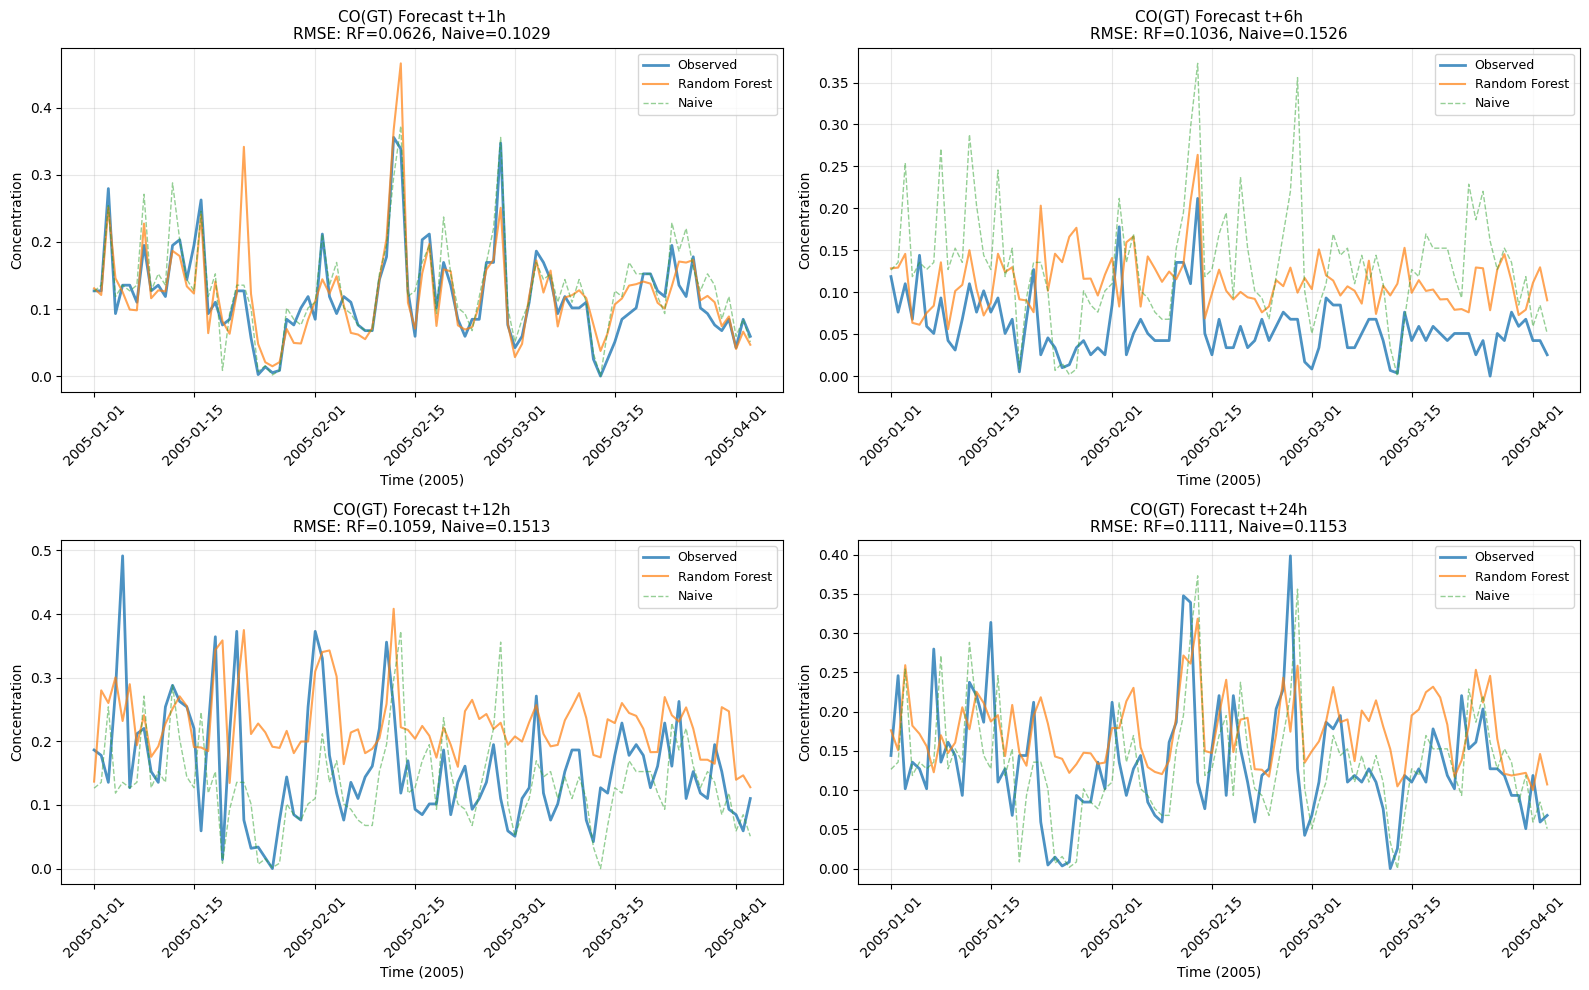

Saved feature importances: results/random_forest_feature_importances.csv


,pollutant,horizon_h,feature,importance
0,CO(GT),1,PT08.S1(CO),0.180146
1,CO(GT),1,PT08.S2(NMHC),0.293762
2,CO(GT),1,PT08.S3(NOx),0.009075
3,CO(GT),1,PT08.S4(NO2),0.003353
4,CO(GT),1,PT08.S5(O3),0.013814


In [9]:
# Predictions plot for CO across all horizons
selected_pollutant = 'CO(GT)'

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, h in enumerate(HORIZONS):
    X_tr, y_tr = prepare_xy(train_df, selected_pollutant, h, feature_cols)
    X_te, y_te = prepare_xy(test_df, selected_pollutant, h, feature_cols)
    
    if X_tr is None or X_te is None:
        continue
    
    model = RandomForestRegressor(**rf_params)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    naive_col = f'{selected_pollutant}_lag1'
    y_naive = X_te[naive_col].values if naive_col in X_te.columns else None
    dt = test_df.loc[X_te.index, 'DateTime']
    
    # Plot every 24 hours for clarity
    step = 24
    dt_subset = dt.iloc[::step]
    y_test_subset = y_te.iloc[::step]
    y_pred_subset = y_pred[::step]
    
    ax = axes[idx]
    ax.plot(dt_subset, y_test_subset.values, label='Observed', linewidth=2, alpha=0.8)
    ax.plot(dt_subset, y_pred_subset, label='Random Forest', linewidth=1.5, alpha=0.7)
    
    if y_naive is not None:
        y_naive_subset = y_naive[::step]
        ax.plot(dt_subset, y_naive_subset, label='Naive', linewidth=1, alpha=0.5, linestyle='--')
    
    rmse_rf = np.sqrt(mean_squared_error(y_te, y_pred))
    rmse_naive = naive_rmse(X_te, y_te, selected_pollutant, h)
    
    ax.set_title(f'{selected_pollutant} Forecast t+{h}h\nRMSE: RF={rmse_rf:.4f}, Naive={rmse_naive:.4f}', fontsize=11)
    ax.set_xlabel('Time (2005)', fontsize=10)
    ax.set_ylabel('Concentration', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

pred_plot_path = PLOTS_DIR / 'rf_predictions_all_horizons.png'
plt.savefig(pred_plot_path, dpi=150, bbox_inches='tight')
print(f"Predictions plot saved: {pred_plot_path}")
plt.show()


# Feature importances
importances_records = []

for h in HORIZONS:
    modeled = [r['pollutant'] for r in results if r['horizon_h'] == h]
    for pol in modeled:
        X_tr, y_tr = prepare_xy(train_df, pol, h, feature_cols)
        if X_tr is None or len(X_tr) == 0:
            continue
        rf_tmp = RandomForestRegressor(**rf_params)
        rf_tmp.fit(X_tr, y_tr)
        for feat, val in zip(X_tr.columns, rf_tmp.feature_importances_):
            importances_records.append({'pollutant': pol, 'horizon_h': h, 'feature': feat, 'importance': float(val)})

fi_df = pd.DataFrame(importances_records)
fi_out = RESULTS_DIR / 'random_forest_feature_importances.csv'
fi_df.to_csv(fi_out, index=False)
print('Saved feature importances:', fi_out)
fi_df.head()

Residuals plot saved: results/plots/rf_residuals_all_horizons.png


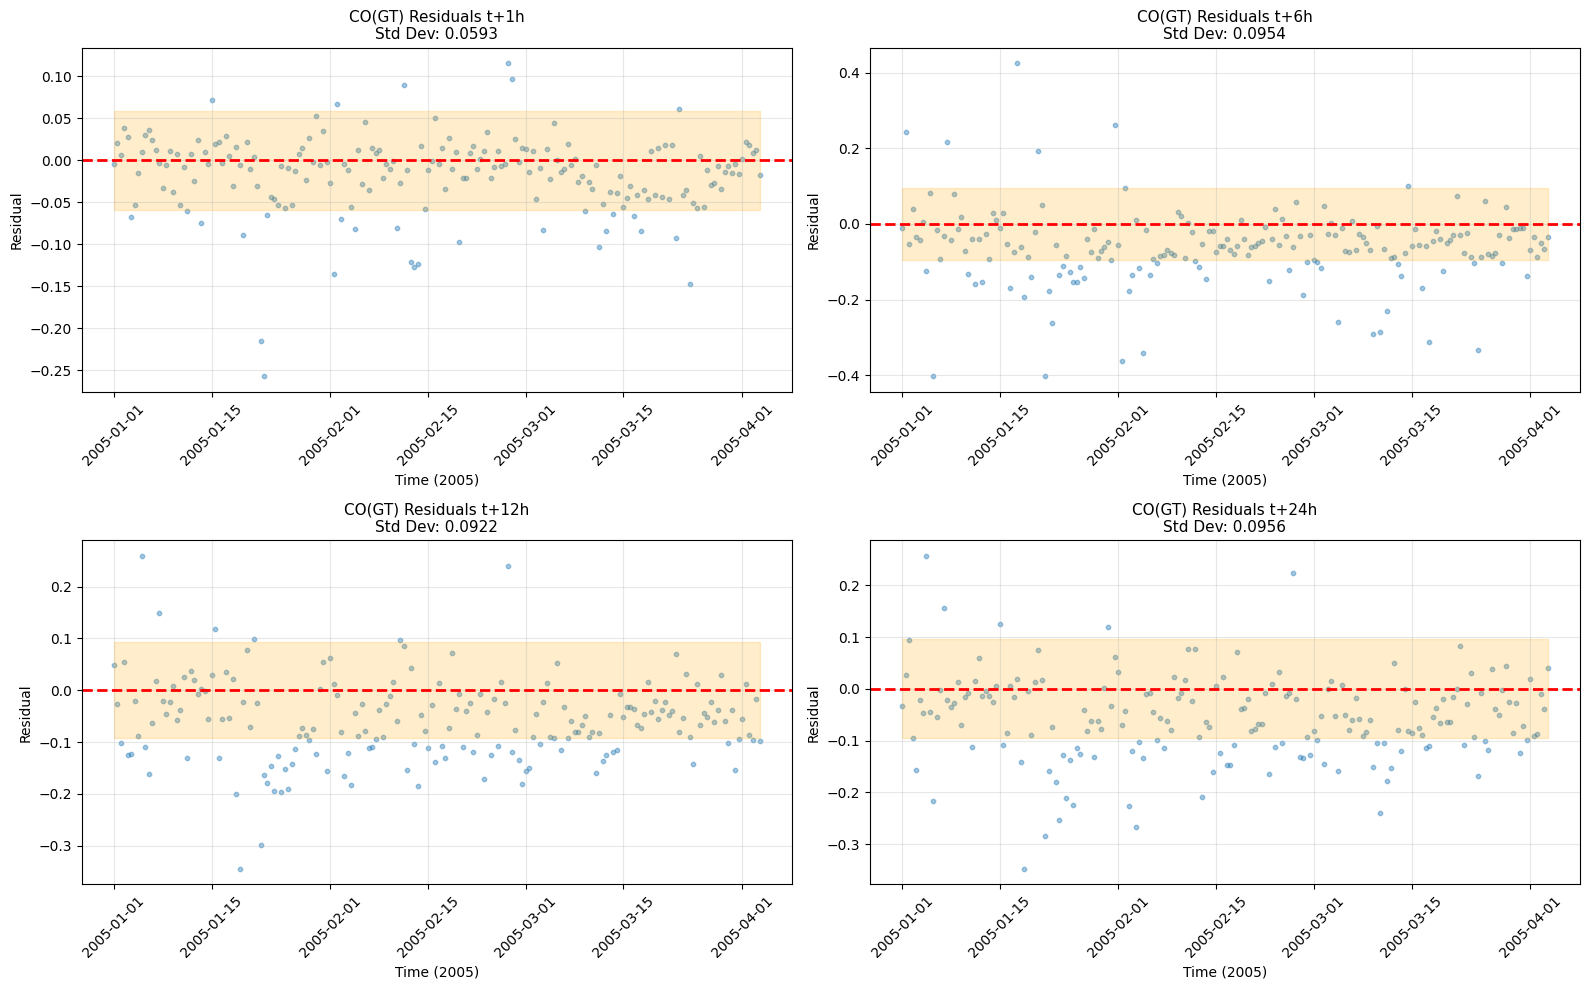

In [10]:
# Residual analysis for CO across all horizons
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, h in enumerate(HORIZONS):
    X_tr, y_tr = prepare_xy(train_df, selected_pollutant, h, feature_cols)
    X_te, y_te = prepare_xy(test_df, selected_pollutant, h, feature_cols)
    
    if X_tr is None or X_te is None:
        continue
    
    model = RandomForestRegressor(**rf_params)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    residuals = y_te - y_pred
    dt = test_df.loc[X_te.index, 'DateTime']
    
    # Plot every 12 hours for clarity
    step = 12
    dt_subset = dt.iloc[::step]
    residuals_subset = residuals.iloc[::step]
    
    ax = axes[idx]
    ax.scatter(dt_subset, residuals_subset, alpha=0.4, s=10)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.fill_between(dt_subset, -residuals.std(), residuals.std(), alpha=0.2, color='orange')
    
    ax.set_title(f'{selected_pollutant} Residuals t+{h}h\nStd Dev: {residuals.std():.4f}', fontsize=11)
    ax.set_xlabel('Time (2005)', fontsize=10)
    ax.set_ylabel('Residual', fontsize=10)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

resid_plot_path = PLOTS_DIR / 'rf_residuals_all_horizons.png'
plt.savefig(resid_plot_path, dpi=150, bbox_inches='tight')
print(f"Residuals plot saved: {resid_plot_path}")
plt.show()
